The mean rotation of simulated molecules in 48 h: 846.1°.


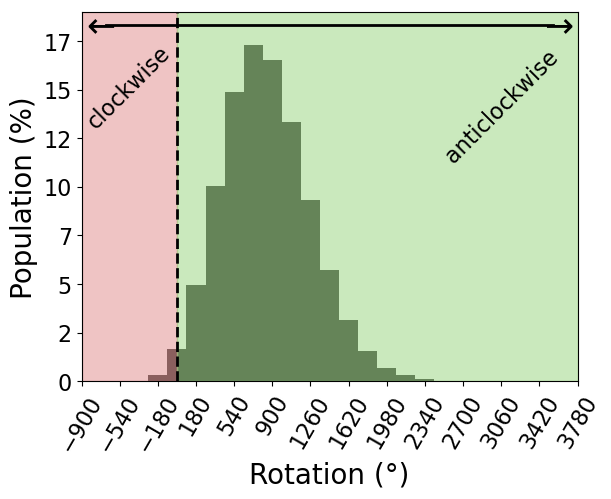

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from math import exp, factorial, log

#Poisson probability formula
def poisson_prob(r):
    return (exp(-log(2)) * log(2) ** r) / factorial(r)

#Array sampler
def drop_random_poisson(arr, drop_prob):
    num_to_drop = min(int(drop_prob * len(arr)), len(arr))
    drop_indices = np.random.choice(len(arr), size=num_to_drop, replace=False)
    return np.delete(arr, drop_indices), arr[drop_indices]

# Constants
time, half_life = 48, 2.48
oxidation_selectivity, reduction_selectivity = 0.938, 0.5
AB_conc = 100 #mM
r_rac, r_red = 0.84, 0.0021*AB_conc
pop_size = 10**7
num_cycles = time / half_life
integer_cycles, partial_cycle = int(num_cycles), num_cycles % 1

# Probabilities
rotation_prob = r_rac/(r_rac+r_red)
forwards_prob = reduction_selectivity * oxidation_selectivity * rotation_prob
backwards_prob = (1-reduction_selectivity) * (1 - oxidation_selectivity) * rotation_prob

prob_per_oxidation = [forwards_prob, 1 - forwards_prob - backwards_prob, backwards_prob]

# Working out rotations per half-life
pop = np.zeros(pop_size, dtype=int)
popped_values = []
mean_samples = []

for r in range(20):
    drop_prob = poisson_prob(r) * (pop_size / len(pop))
    if r > 0:
        pop += np.random.choice([180, 0, -180], size=len(pop), p=prob_per_oxidation)
    pop, popped_this_cycle = drop_random_poisson(pop, drop_prob)
    popped_values.extend(popped_this_cycle)

# Normalize probabilities
unique_values, counts = np.unique(popped_values, return_counts=True)
normalized_probabilities = counts / counts.sum()

# Full cycles
pop = np.zeros(pop_size, dtype=int)
for _ in range(integer_cycles):
    samples = np.random.choice(unique_values, size=pop_size, p=normalized_probabilities)
    pop += samples

# Partial cycle
if partial_cycle > 0:
    partial_cycle_probs = normalized_probabilities * partial_cycle
    partial_cycle_probs[unique_values == 0] = 0
    partial_cycle_probs[unique_values == 0] = 1 - partial_cycle_probs.sum()
    samples = np.random.choice(unique_values, size=pop_size, p=partial_cycle_probs)
    pop += samples

# Plot results
bin_edges = np.arange(pop.min() - 90, pop.max() + 90, 180)
plt.hist(pop, bins=bin_edges, color='#333333')
plt.xlabel('Rotation (°)', fontsize=20)
plt.ylabel('Population (%)', fontsize=20)
plt.xticks(np.arange(pop.min(), pop.max() + 360, 360), fontsize=16, rotation=60)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x * 100 / pop_size)}'))
plt.gca().tick_params(axis='y', labelsize=16)
plt.axvline(x=0, color='black', linestyle='--', linewidth=2)
plt.axhline(y=1832000, xmin=.05, xmax=.95, color='black', linewidth=2)
plt.axvspan(min(pop), 0, color='#E18B8A', alpha=0.5)
plt.axvspan(0, max(pop), color='#97D57D', alpha=0.5)
plt.annotate('clockwise', xy=(0, 0), xytext=(min(pop)/2, 1750000), fontsize=16, ha='center', va='top', rotation=45)
plt.annotate('anticlockwise ', xy=(0, 0), xytext=(max(pop)*(8.8/9), 1750000), fontsize=16, ha='right', va='top', rotation=45)
plt.annotate('\u2190', xy=(0, 0), xytext=(min(pop)+180, 1825000), fontsize=25, ha='center', va='center')
plt.annotate('\u2192', xy=(0, 0), xytext=(max(pop)-180, 1825000), fontsize=25, ha='center', va='center')
plt.ylim(0,1900000)
plt.xlim(min(pop), max(pop))
print(f"The mean rotation of simulated molecules in 48 h:{np.mean(pop): .3g}°.")
plt.show()